# Analyse de Portefeuille et Évaluation d'Actifs avec le Modèle CAPM

## Résumé Exécutif

Ce projet est une analyse quantitative complète d'un portefeuille d'actions françaises du CAC 40, menée en **Python**. L'objectif est de passer de données de marché brutes à une évaluation du risque systématique et du rendement attendu pour chaque actif, en utilisant le **Modèle d'Évaluation des Actifs Financiers (CAPM)**.

**Portefeuille Analysé :**
*   LVMH (`MC.PA`)
*   TotalEnergies (`TTE.PA`)
*   BNP Paribas (`BNP.PA`)
*   Airbus (`AIR.PA`)
*   **Indice de Marché :** CAC 40 (`^FCHI`)

**Méthodologie :**
1.  **Collecte de Données :** Téléchargement de 7 ans de données de prix journaliers via l'API `yfinance`.
2.  **Analyse Exploratoire :** Visualisation des performances normalisées (Base 100) pour une comparaison juste.
3.  **Calcul des Rendements :** Transformation des prix en rendements journaliers avec `pandas`.
4.  **Calcul du Bêta :** Pour chaque action, le Bêta a été déterminé par une **régression linéaire** (Moindres Carrés Ordinaires) de ses rendements sur ceux du marché, en utilisant la librairie `statsmodels`.
5.  **Application du CAPM :** Estimation du rendement annuel attendu pour chaque actif en fonction de son Bêta et d'hypothèses de marché (Taux sans risque, Prime de risque du marché).

**Principales Conclusions :**
*   L'analyse a révélé que les actions **Airbus (Bêta = 1.45)** et **BNP Paribas (Bêta = 1.32)** présentent le risque systématique le plus élevé, amplifiant les mouvements du marché.
*   Conformément à la théorie financière, ces actions à plus haut risque sont aussi celles qui offrent le **rendement attendu le plus élevé** selon le modèle CAPM (10.26% et 9.60% respectivement).
*   **TotalEnergies** s'est avérée être l'action la plus "défensive" du portefeuille, avec un Bêta proche de 1.
---

In [1]:
# Importation des librairies essentielles
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Configuration esthétique pour les graphiques
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

### Étape 2 : Définition du Portefeuille et Téléchargement des Données
Dans la deuxième cellule, nous allons définir notre liste d'actifs et la période d'analyse, puis utiliser `yfinance` pour télécharger toutes les données d'un seul coup.

In [2]:
# Définition des tickers pour notre portefeuille et le marché
tickers = ["MC.PA", "TTE.PA", "BNP.PA", "AIR.PA", "^FCHI"]

# Définition de la période d'analyse (7 ans)
start_date = "2018-08-01"
end_date = "2025-08-31"

# Téléchargement des données pour tous les tickers sur la période définie
data_all = yf.download(tickers, start=start_date, end=end_date)

# Utilisation des prix de clôture ('Close') à partir de data_all
close_prices = data_all["Close"]

# Afficher les 5 premières lignes pour vérifier
print(close_prices.head())

# Afficher les 5 dernières lignes pour vérifier
print(close_prices.tail())

/tmp/ipykernel_3470/3029212544.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_all = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed

Ticker          AIR.PA     BNP.PA       MC.PA     TTE.PA        ^FCHI
Date                                                                 
2018-08-01   99.571297  37.743271  266.359131  36.768826  5498.370117
2018-08-02   99.459206  37.205151  262.566071  36.417568  5460.979980
2018-08-03  100.654816  37.068924  263.547821  36.304909  5478.979980
2018-08-06  100.710854  36.803268  266.091309  36.417568  5477.180176
2018-08-07  101.813049  37.150661  270.687592  37.086945  5521.310059
Ticker          AIR.PA     BNP.PA       MC.PA     TTE.PA        ^FCHI
Date                                                                 
2025-08-25  180.539993  80.430000  488.049988  54.099998  7843.040039
2025-08-26  179.880005  77.029999  486.250000  52.910000  7709.810059
2025-08-27  178.259995  76.529999  502.000000  53.209999  7743.930176
2025-08-28  178.619995  76.900002  513.099976  53.099998  7762.600098
2025-08-29  179.059998  76.830002  504.100006  53.500000  7703.899902


### Étape 3 : Analyse Exploratoire - Visualisation des Prix

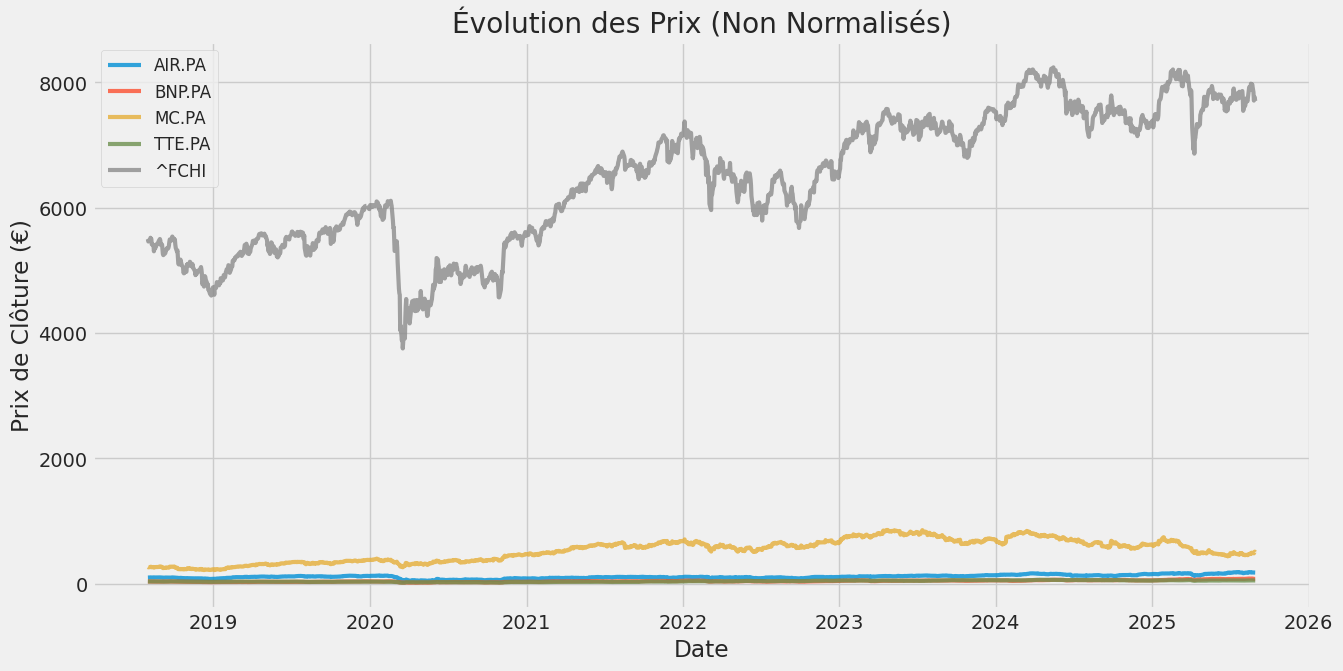

In [3]:
# Visualisation de l'évolution des prix de clôture
plt.figure(figsize=(14, 7))
for c in close_prices.columns.values:
    plt.plot(close_prices.index, close_prices[c], lw=3, alpha=0.8, label=c)
plt.title("Évolution des Prix (Non Normalisés)")
plt.ylabel("Prix de Clôture (€)")
plt.xlabel("Date")
plt.legend(loc="upper left", fontsize=12)
plt.show()

### Étape 4 : Normalisation en Base 100 (Version Corrigée)

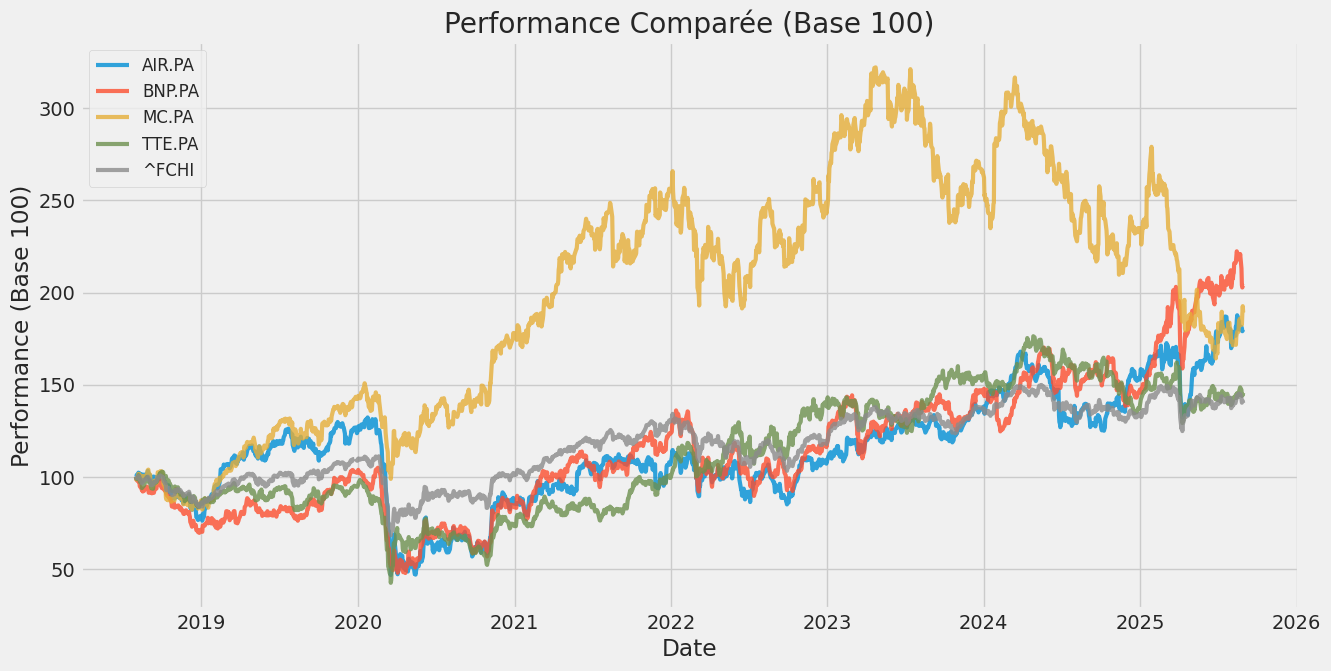

In [4]:
# Normalisation des données en Base 100
# La formule : (Prix actuel / Premier prix) * 100
base100 = close_prices / close_prices.iloc[0] * 100

# Visualisation des données normalisées
plt.figure(figsize=(14, 7))
for c in base100.columns.values:
    plt.plot(base100.index, base100[c], lw=3, alpha=0.8, label=c)
plt.title("Performance Comparée (Base 100)")
plt.ylabel("Performance (Base 100)")
plt.xlabel("Date")
plt.legend(loc="upper left", fontsize=12)
plt.show()

### Étape 5 : Calcul des Rendements Journaliers

In [5]:
# Calcul des rendements journaliers en utilisant la méthode pct_change()
# Cette méthode calcule automatiquement : (valeur_aujourdhui - valeur_hier) / valeur_hier
daily_returns = close_prices.pct_change()

# La première ligne sera remplie de 'NaN' (Not a Number) car il n'y a pas de jour précédent
# Nous la supprimons pour avoir un DataFrame propre
daily_returns = daily_returns.dropna()

# Afficher les 5 premières lignes des rendements pour vérifier
print(daily_returns.head())

Ticker        AIR.PA    BNP.PA     MC.PA    TTE.PA     ^FCHI
Date                                                        
2018-08-02 -0.001126 -0.014257 -0.014240 -0.009553 -0.006800
2018-08-03  0.012021 -0.003661  0.003739 -0.003094  0.003296
2018-08-06  0.000557 -0.007167  0.009651  0.003103 -0.000328
2018-08-07  0.010944  0.009439  0.017273  0.018381  0.008057
2018-08-08 -0.010092 -0.002567 -0.012858 -0.008220 -0.003515


/tmp/ipykernel_3470/2702475685.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = close_prices.pct_change()


### Étape 6 : Calcul du Bêta pour une Action (Exemple : LVMH)
Maintenant que nous avons les rendements, nous pouvons calculer le Bêta. Rappelez-vous, le Bêta est la pente de la droite de régression entre les rendements de l'action (variable dépendante Y) et les rendements du marché (variable indépendante X).

In [6]:
# Préparation des données pour la régression
# Variable Indépendante (X) : les rendements du marché (CAC 40)
X = daily_returns["^FCHI"]
# On ajoute une constante (l'intercept) au modèle, c'est une pratique standard en régression
X = sm.add_constant(X)

# Variable Dépendante (Y) : les rendements de notre action (LVMH)
Y = daily_returns["MC.PA"]

# Création et entraînement du modèle de régression linéaire (Moindres Carrés Ordinaires)
model = sm.OLS(Y, X).fit()

# Le Bêta est le coefficient de notre variable X ('^FCHI')
beta_lvmh = model.params["^FCHI"]

# Afficher le résumé complet de la régression pour plus de détails
print(model.summary())

print(f"\nLe Bêta calculé pour LVMH (MC.PA) est : {beta_lvmh:.4f}")

                            OLS Regression Results                            
Dep. Variable:                  MC.PA   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     2988.
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:26:30   Log-Likelihood:                 5543.7
No. Observations:                1814   AIC:                        -1.108e+04
Df Residuals:                    1812   BIC:                        -1.107e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.777      0.4

### Étape 7 : Calcul du Bêta pour l'Ensemble du Portefeuille

Au lieu de copier-coller le code pour chaque action, nous allons créer une boucle for. C'est une pratique de programmation essentielle qui montre votre capacité à écrire du code efficace et non répétitif.

In [7]:
# Création d'un dictionnaire pour stocker les bêtas de chaque action
betas = {}

# Boucle à travers chaque ticker de notre portefeuille (sauf le marché lui-même)
for ticker in tickers:
    if ticker != "^FCHI":
        # Préparation des données pour la régression (comme avant)
        X = daily_returns["^FCHI"]
        X = sm.add_constant(X)
        Y = daily_returns[ticker]

        # Entraînement du modèle
        model = sm.OLS(Y, X).fit()

        # Stockage du bêta dans notre dictionnaire
        # model.params[1] est le coefficient de notre variable X, c'est une façon robuste de récupérer le bêta
        betas[ticker] = model.params[1]

# Affichage des résultats de manière propre
print("--- Bêtas calculés pour chaque action ---")
for ticker, beta in betas.items():
    print(f"Bêta pour {ticker}: {beta:.4f}")

--- Bêtas calculés pour chaque action ---
Bêta pour MC.PA: 1.2190
Bêta pour TTE.PA: 1.0153
Bêta pour BNP.PA: 1.3196
Bêta pour AIR.PA: 1.4516


/tmp/ipykernel_3470/3253986146.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = model.params[1]
/tmp/ipykernel_3470/3253986146.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = model.params[1]
/tmp/ipykernel_3470/3253986146.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = model.params[1]
/tmp/ipykernel_3470/3253986146.py:17: FutureWarning: Series.__getitem__ treating keys as

### Étape 8 : Application du Modèle CAPM

Maintenant que nous avons le Bêta pour chaque action, nous pouvons appliquer la formule du CAPM pour estimer le rendement annuel attendu pour chacune, en fonction de son risque.

#### Formule du CAPM :
Rendement Attendu = Taux Sans Risque + Bêta * (Rendement Attendu du Marché - Taux Sans Risque)

In [8]:
# --- Hypothèses Financières pour le CAPM ---

# 1. Taux Sans Risque (Risk-Free Rate)
# Nous utilisons une approximation du rendement de l'obligation d'État française (OAT 10 ans).
# Prenons une valeur plausible de 3.0% par an.
risk_free_rate = 0.03

# 2. Rendement Attendu du Marché (Expected Market Return)
# C'est le rendement annuel que l'on anticipe pour le CAC 40.
# Une moyenne historique se situe souvent autour de 8%.
market_return = 0.08

# La Prime de Risque du Marché est la différence entre les deux
market_risk_premium = market_return - risk_free_rate

# --- Application du CAPM ---

# Dictionnaire pour stocker les rendements attendus
expected_returns = {}

# Boucle à travers nos bêtas calculés
for ticker, beta in betas.items():
    # Application de la formule du CAPM
    expected_return = risk_free_rate + beta * market_risk_premium
    expected_returns[ticker] = expected_return

# Affichage des résultats
print("\n--- Rendements Annuels Attendus (CAPM) ---")
for ticker, er in expected_returns.items():
    print(
        f"Rendement attendu pour {ticker}: {er:.2%}"
    )  # Le format :.2% affiche joliment en pourcentage


--- Rendements Annuels Attendus (CAPM) ---
Rendement attendu pour MC.PA: 9.10%
Rendement attendu pour TTE.PA: 8.08%
Rendement attendu pour BNP.PA: 9.60%
Rendement attendu pour AIR.PA: 10.26%


## Interprétation des Résultats
### Analyse des Bêtas (La Mesure du Risque Systématique)

BNP Paribas (BNP.PA) et Airbus (AIR.PA) sont les plus "agressives" : Avec des bêtas de 1.32 et 1.45, ces deux actions ont tendance à amplifier les mouvements du CAC 40. Si le marché prend +10%, elles pourraient prendre +13% ou +14.5%. Inversement, en cas de crise, elles risquent de chuter plus lourdement. C'est typique pour une banque (sensible aux cycles économiques) et pour un grand industriel (sensible aux carnets de commande et à la conjoncture).

LVMH (MC.PA) est une action "dynamique" : Avec un bêta de 1.22, elle est plus volatile que le marché, mais moins que les deux précédentes. Le luxe est cyclique, mais la puissance de la marque LVMH lui confère une certaine résilience.

TotalEnergies (TTE.PA) est la plus "défensive" du lot : Son bêta de 1.015 est très proche de 1. Cela signifie que TotalEnergies se comporte quasiment comme le marché dans son ensemble. C'est une action qui suit le CAC 40 de très près.

### Conclusion sur le risque : 
Le portefeuille est clairement orienté "pro-cyclique" ou "agressif", avec 3 des 4 actions qui amplifient les mouvements du marché.
Analyse des Rendements Attendus (La Rémunération du Risque)

Le modèle CAPM nous dit quel rendement un investisseur devrait théoriquement exiger pour accepter de prendre le risque mesuré par le Bêta.

#### La logique est respectée : 
Vous pouvez le constater, l'ordre est parfait. Airbus, l'action la plus risquée (Bêta = 1.45), est aussi celle qui offre le rendement attendu le plus élevé (10.26%). À l'inverse, TotalEnergies, la moins risquée, offre le rendement attendu le plus faible (8.08%).

#### Ce que cela signifie concrètement : 
Un investisseur rationnel ne serait pas intéressé par Airbus si on lui promettait seulement 8% de rendement, car il pourrait obtenir un rendement similaire avec TotalEnergies pour un risque bien moindre. Le rendement supplémentaire de +2.18% (10.26% - 8.08%) est la "prime" que le marché exige pour supporter la volatilité supplémentaire d'Airbus.